In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import glob
import pandas as pd 
import seaborn as sns

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Lambda, Dropout

import tensorflow as tf

Using TensorFlow backend.


In [2]:
image_names = []
steers = []
speeds = []

image_data = []
target = None


In [3]:
# load all image name
image_paths = glob.glob("/home/namntse05438/Cuoc_Dua_So/Ros_python/image_data/*.jpg")
print("Total read images: ", len(image_paths))
for path in image_paths:
    image_name = path.split("/")[-1]
    # print(image_name)
    # delete ".jpg" extension
    image_name = image_name[:-4]
    # print(image_name)
    image_names.append(image_name)
    raw = image_name.split("_")
    speed = raw[1]
    steer = raw[2]
    steers.append(steer)
    speeds.append(speed)
    # print(speed)
    # print(steer)
    # exit()
    
# make dataframe containing info of all images (name, speed, steer)
data = pd.DataFrame({"name":image_names,"path":image_paths, "speed":speeds, "steer":steers})
data.head()

Total read images:  5557


,name,path,speed,steer
0,1546014233.95_50_0.00165315992043,/home/namntse05438/Cuoc_Dua_So/Ros_python/imag...,50,0.00165315992043
1,1546014103.21_50_0.0150572402819,/home/namntse05438/Cuoc_Dua_So/Ros_python/imag...,50,0.0150572402819
2,1546014058.02_50_0.112754050913,/home/namntse05438/Cuoc_Dua_So/Ros_python/imag...,50,0.112754050913
3,1546014231.18_50_-2.02498203262e-10,/home/namntse05438/Cuoc_Dua_So/Ros_python/imag...,50,-2.02498203262e-10
4,1546014078.86_50_0.0200879615841,/home/namntse05438/Cuoc_Dua_So/Ros_python/imag...,50,0.0200879615841


In [4]:
data['steer'] = data['steer'].astype(float)

/home/namntse05438/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


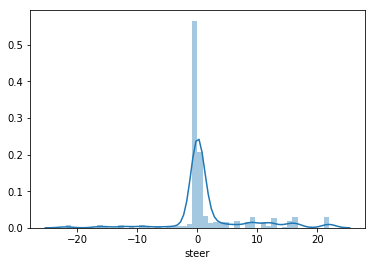

In [5]:
# data analysis
sns.distplot(data['steer'])

In [15]:
# split data into mid and left_right by a threshold
# mid is usually larger because when driving on the road, most of the time we go straight
thresh = 1

In [16]:
mid = data[(data['steer']<thresh) & (data['steer']>-thresh)]
print("size of mid data: ", len(mid))

size of mid data:  3783


In [19]:
# we sample mid data to be about twice as much as left_right
# Because for some next steps, we will augment left_right by vertically flipping the image and target
mid_sample = mid.sample(len(left_right)*2)
print("length of mid_sample: ", len(mid_sample))

length of mid_sample:  3548


In [17]:
left_right = data[(data['steer']>=thresh) | (data['steer']<=-thresh)]
print("size of left right data: ", len(left_right))

size of left right data:  1774


In [21]:
# read mid_image_data and mid_target
mid_image_data = []
mid_target = []

for path in mid_sample['path']:
    img = cv2.imread(path)
    mid_image_data.append(img)

mid_image_data = np.array(mid_image_data)
mid_target = np.array(mid_sample['steer']).reshape(-1,1)

print("Shape of mid_image_data: ", mid_image_data.shape)
print("Shape of mid_target: ", mid_target.shape)

Shape of mid_image_data:  (3548, 240, 320, 3)
Shape of mid_target:  (3548, 1)


In [22]:
def flip_image(img):
    flipped = cv2.flip(img, 1)
    return flipped


In [25]:
# read left_right image and perform flip to augment data
left_right_image_data = []
left_right_target = []

for index, row in left_right.iterrows():
    img = cv2.imread(row['path'])
    tgt = row['steer']
    left_right_image_data.append(img)
    left_right_image_data.append(flip_image(img))
    left_right_target.append(tgt)
    left_right_target.append(-tgt)
    
left_right_image_data = np.array(left_right_image_data)
left_right_target = np.array(left_right_target).reshape(-1,1)

print("Shape of left_right_image_data: ", left_right_image_data.shape)
print("Shape of left_right_target: ", left_right_target.shape)

Shape of left_right_image_data:  (3548, 240, 320, 3)
Shape of left_right_target:  (3548, 1)


In [26]:
image_data = np.vstack([mid_image_data, left_right_image_data])
target = np.vstack([mid_target, left_right_target])

print("Shape of image_data: ", image_data.shape)
print("Shape of target: ", target.shape)

Shape of image_data:  (7096, 240, 320, 3)
Shape of target:  (7096, 1)


/home/namntse05438/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


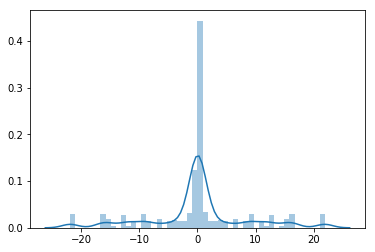

In [27]:
sns.distplot(target)

In [28]:
# define model
#model.reset_states()
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(240, 320,3)))
model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())


/home/namntse05438/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2))`
  """
/home/namntse05438/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  
/home/namntse05438/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  import sys
/home/namntse05438/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/home/namntse05438/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 240, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 158, 24)      1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 37, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 35, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 23, 33, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 33, 64)        0         
__________

In [ ]:
model.fit(image_data, target, epochs=10)

Epoch 1/10
7096/7096 [==============================] - 17s 2ms/step - loss: 2.1586
Epoch 2/10
7096/7096 [==============================] - 18s 2ms/step - loss: 2.0859
Epoch 3/10
7096/7096 [==============================] - 18s 2ms/step - loss: 1.9591
Epoch 4/10
7096/7096 [==============================] - 18s 2ms/step - loss: 2.0193
Epoch 5/10
7096/7096 [==============================] - 18s 2ms/step - loss: 2.0250
Epoch 6/10
7096/7096 [==============================] - 18s 2ms/step - loss: 2.0212
Epoch 7/10
7096/7096 [==============================] - 18s 2ms/step - loss: 1.8853
Epoch 8/10
2944/7096 [===========>..................] - ETA: 10s - loss: 1.8581

In [102]:
idx = int(len(image_data)*np.random.random())
test1 = image_data[idx]
print(test1.shape)
cv2.imshow("frame", test1.astype(int))
cv2.waitKey(0)
cv2.destroyAllWindows()

(240, 320, 3)


In [105]:
model.predict(test1.reshape(1,240,320,3))

array([[8.822712]], dtype=float32)

In [111]:
model.save_weights("my_model_3.h5")